# Problem 1
## 1.a Gibbs sampler

In [1]:
gibbs_sampler <- function(X, Y, alpha_init = rep(0,dim(X)[2]), sigma2_init = 1,
                          delta = 10, lambda = 10, mu = rep(0,dim(X)[2]),
                          Omega = diag(dim(X)[2]), MCsamplesize = 1000){

    # dims of X
  n <- dim(X)[1] # sample size
  p <- dim(X)[2] # number of covariates in linear regression model/alpha-parameters

  # set starting values for parameter chains
    # variables where generated values will be saved
  alpha_chain      <- matrix(NA, MCsamplesize, p)
  sigma2_chain     <- rep   (NA, MCsamplesize)
    # first values for both chains
  alpha_chain[1,]  <- alpha_init  # [0] * p
  sigma2_chain[1]  <- sigma2_init  # [1]

  # create parameter chain
  for (i in 2:(MCsamplesize)){

    alpha_chain[i,]  <- alpha_chain[i-1,]
    sigma2_chain[i]  <- sigma2_chain[i-1]

    for (j in 1:p){

      s_j <- 1 / (Omega[j, j] + sigma2_chain[i]^(-1) * sum(X[, j]^2))
      m_j <- s_j*(mu[j]*Omega[j, j]
                  - sum(Omega[j, -j]*(alpha_chain[i, -j] - mu[-j]))
                  + sigma2_chain[i]^(-1)*sum(X[, j]*(Y - X[, -j]%*%alpha_chain[i, -j])))
      alpha_chain[i,j] <- rnorm(1, m_j, sqrt(s_j)) # rnorm accepts sd, not var

    }

    sigma2_chain[i] <- 1 / rgamma(n=1, shape=delta + n/2,
                                  rate=lambda + 1/2*sum( (Y - X%*%alpha_chain[i, ])^2 ))
  }

  return(list("alpha" = alpha_chain, "sigma2" = sigma2_chain))

}

## 1.b

In [2]:
set.seed(999)
samplesize <- 200
dim        <- 3
alpha_real <- c(-2, 0, 4)
sigma_real <- 2
X <- matrix(rnorm(samplesize*dim), nrow = samplesize, n = dim)
Y <- as.vector(X%*%alpha_real + rnorm(samplesize, 0, sigma_real))  # sd, not var


In [3]:
n <- dim(X)[1] # sample size
p <- dim(X)[2] # number of covariates in linear regression model/alpha-parameters

sigma2_real <- sigma_real^2

In [4]:
out <- gibbs_sampler(X, Y)
sigma2 <- out$sigma2
alpha <- out$alpha

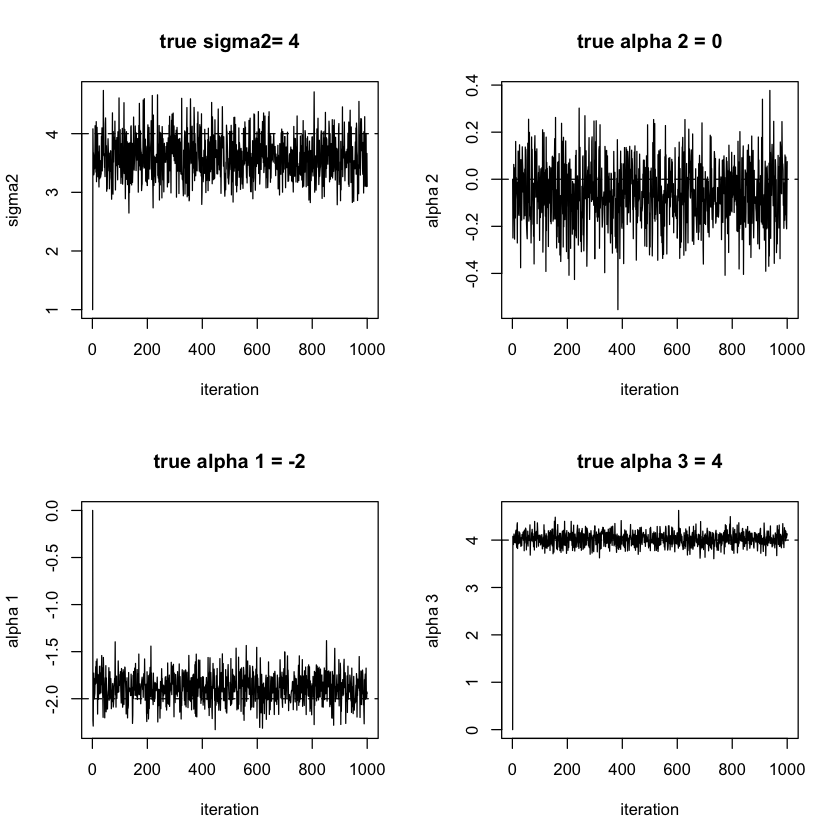

In [5]:
par(mfcol = c(2, 2))
plot(sigma2, ylab = "sigma2", xlab = "iteration", main = paste("true sigma2=",
    round(sigma2_real, digits = 2)), type = "l")
abline(h = sigma2_real, lty = 2)

for (i in 1:p){
    plot(alpha[,i], ylab = paste("alpha",i), xlab = "iteration", main = paste(
        "true alpha", i, "=", round(alpha_real[i], digits = 2)), type = "l")
    abline(h = alpha_real[i], lty = 2)
}

### Intrepret traceplots
As we can see, the chains converge quite fast. From the graph it can be seen that the chains converge in 10-20 iterations. Let's choose a burn-in period of 100 to be safe.

In [6]:
# no burnin values
sigma2_nb <- sigma2[101:n]
alpha_nb  <- alpha[101:n,]

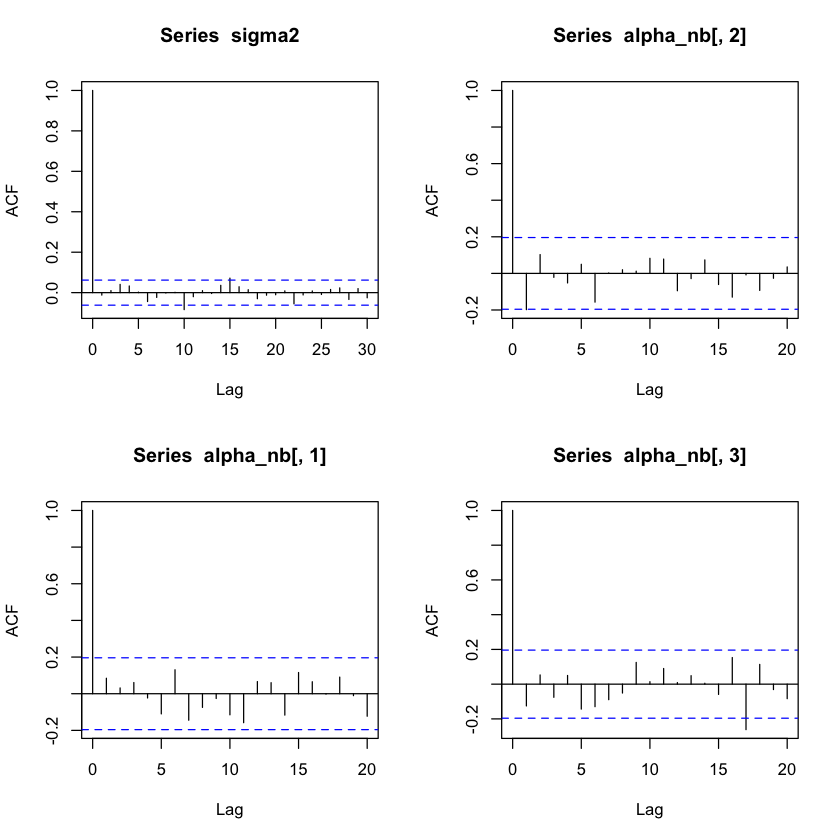

In [7]:
par(mfcol = c(2, 2))
acf(sigma2)
acf(alpha_nb[,1])
acf(alpha_nb[,2])
acf(alpha_nb[,3])

### Intrepret ACF plots
We can see, that autocorrelation is low for each of the chains. So we can proceed without throwing away every n'th sample.

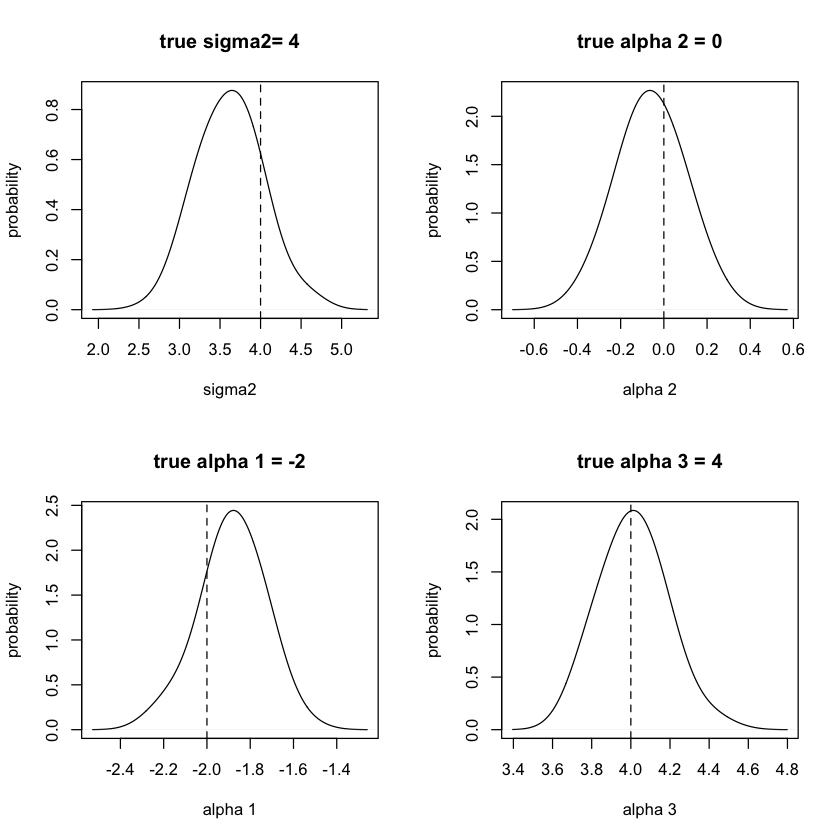

In [8]:
# density estimates
par(mfcol = c(2, 2))

hw <- 2 * (summary(sigma2_nb)[5] - summary(sigma2_nb)[2])
plot(density(sigma2_nb, width = hw), xlab = "sigma2", ylab = "probability",
    type = "l",main="")
abline(v = sigma2_real, lty = 2)
title(paste("true sigma2=", round(sigma2_real, digits = 2)))

for (i in 1:p){
    hw <- 2 * (summary(alpha_nb[,i])[5] - summary(alpha_nb[,i])[2])
    plot(density(alpha_nb[,i], width = hw), xlab = paste("alpha",i), ylab = "probability",
        type = "l",main="")
    abline(v = alpha_real[i], lty = 2)
    title(paste("true alpha",i, "=", round(alpha_real[i], digits = 2)))
}

In [9]:
ord_lr <- lm(Y ~ X - 1)  # -1 to get read of intercept
ord_lr
summary(ord_lr)


Call:
lm(formula = Y ~ X - 1)

Coefficients:
     X1       X2       X3  
-1.9238  -0.0587   4.1003  



Call:
lm(formula = Y ~ X - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3286 -1.5298 -0.1412  1.1600  5.2405 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
X1  -1.9238     0.1510 -12.740   <2e-16 ***
X2  -0.0587     0.1363  -0.431    0.667    
X3   4.1003     0.1465  27.980   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.956 on 197 degrees of freedom
Multiple R-squared:  0.8355,	Adjusted R-squared:  0.833 
F-statistic: 333.4 on 3 and 197 DF,  p-value: < 2.2e-16


### Intrepret `lm` results

Coefficients of the linear regression are `-1.9238  -0.0587   4.1003` and estimated standard error is 1.956, which means that estimated `sigma2=3.83`.
These values are closer to the true values, than the maximum of the posterior densities estimated by Gibbs sampler.

Especially bad is the posterior of `sigma2` with peak around 3.5.

## 1.c

In [10]:
set.seed(42)
samplesize <- 200
dim        <- 3
alpha_real <- c(-2, 0, 4)
sigma_real <- 2
X <- 0.1*matrix(rnorm(samplesize*dim), nrow = samplesize, ncol = dim) +
     matrix(rep(rnorm(samplesize), 3), nrow = samplesize, ncol = dim)
Y <- as.vector(X%*%alpha_real + rnorm(samplesize, 0, sigma_real))

In [11]:
alpha_init <- rep(20,3)

In [12]:
sigma_init <- 1
tau_init <- 1 / sigma_init^2 

In [13]:
mah_model <- function(){
    for (i in 1:n){
        Y.mu[i] <- X[i,] %*% alpha
        Y[i] ~ dnorm(Y.mu[i], tau)
    }

    tau ~ dgamma(delta, lambda)
    alpha ~ dmnorm(mu, Omega)

    sigma2 <- 1 / tau
}

mah_data=list(X=X, Y=Y, n=samplesize,
                delta = 10,
                lambda = 10,
                mu = rep(0,dim(X)[2]),
                Omega = diag(dim(X)[2]))

In [14]:
mah_mcmc <- R2jags::jags(
    data = mah_data, 
    inits=list(list(alpha=alpha_init, tau=tau_init)),
    parameters.to.save = c("alpha","tau", "sigma2"),
    n.iter = samplesize, 
    n.chains = 1,
    n.thin = 1,
    n.burnin = 0, # 100 iterations are run for adaption
    model.file = mah_model)

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 2
   Total graph size: 1221

Initializing model



In [15]:
structure(mah_mcmc)

Inference for Bugs model at "/var/folders/7n/fcgysll141n_czqxfkwtd68r0000gn/T//Rtmp2npESX/model434b2ee751a9.txt", fit using jags,
 1 chains, each with 200 iterations (first 0 discarded)
 n.sims = 200 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%
alpha[1]   0.180   0.748  -1.310  -0.301   0.168   0.666   1.481
alpha[2]   0.212   0.661  -0.853  -0.277   0.193   0.630   1.609
alpha[3]   1.665   0.668   0.266   1.268   1.659   2.122   2.970
sigma2    17.903 186.095   3.805   4.387   4.704   5.067   5.772
tau        0.212   0.028   0.173   0.197   0.213   0.228   0.263
deviance 896.589  74.490 886.429 889.195 890.731 893.061 898.248

DIC info (using the rule, pD = var(deviance)/2)
pD = 2774.4 and DIC = 3671.0
DIC is an estimate of expected predictive error (lower deviance is better).

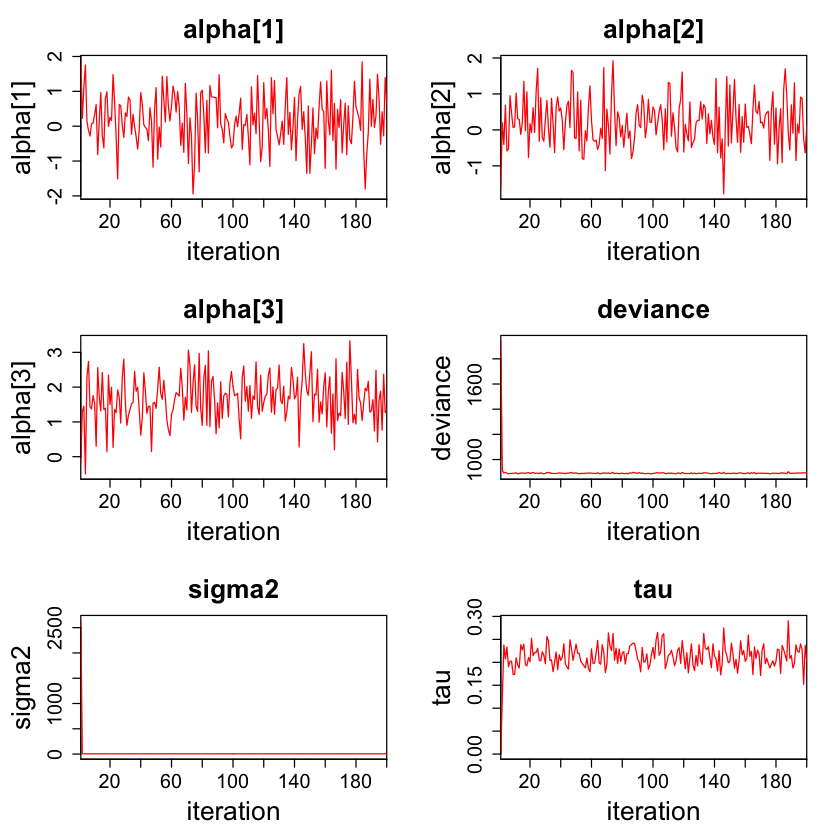

In [16]:
rafalib::bigpar(3,2)
R2jags::traceplot(mah_mcmc,mfrow=c(3,2))

In [17]:
mah_mcmc

Inference for Bugs model at "/var/folders/7n/fcgysll141n_czqxfkwtd68r0000gn/T//Rtmp2npESX/model434b2ee751a9.txt", fit using jags,
 1 chains, each with 200 iterations (first 0 discarded)
 n.sims = 200 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%
alpha[1]   0.180   0.748  -1.310  -0.301   0.168   0.666   1.481
alpha[2]   0.212   0.661  -0.853  -0.277   0.193   0.630   1.609
alpha[3]   1.665   0.668   0.266   1.268   1.659   2.122   2.970
sigma2    17.903 186.095   3.805   4.387   4.704   5.067   5.772
tau        0.212   0.028   0.173   0.197   0.213   0.228   0.263
deviance 896.589  74.490 886.429 889.195 890.731 893.061 898.248

DIC info (using the rule, pD = var(deviance)/2)
pD = 2774.4 and DIC = 3671.0
DIC is an estimate of expected predictive error (lower deviance is better).

# Problem 2

## 2.a

### Full Conditionals

$$
\begin{aligned}
\pi(\mu_{1}, \mu_{2}) &  \sim \ell (\mu_{1}, \mu_{2}) \cdot p (\mu_{1}, \mu_{2})\\
&=\ell (\mu_{1}, \mu_{2}) \cdot 1\\
&=\ell (\mu_{1}, \mu_{2}) \\
&= N_{n}  (y_{1}, \ldots y_{n} \mid \mu, \Sigma) \\
& \sim \prod_{i=1}^{n} \operatorname{exp}\left\{-\frac{1}{2}(y_{i}-\mu)^{\top} \Sigma^{-1}(y_{i}-\mu)\right\} \\
&\sim \prod_{i=1}^{n} \operatorname{exp}\left\{-\frac{1}{2}\left[y_{i}^{\top} \Sigma^{-1} y_{i}-2 \mu^{\top} \Sigma^{-1} y_{i}+\mu^{\top} \Sigma^{-1} \mu\right]\right\}\\
&\sim \prod_{i=1}^{n} \exp \left\{-\frac{1}{2}\left[-2 \mu^{\top} \Sigma^{-1} y_{i}+\mu^{\top} \Sigma^{-1} \mu\right]\right\}\\
&=\operatorname{exp}\left\{-\frac{1}{2} \sum_{i=1}^{n}\left[-2 \mu^{\top} \Sigma^{-1} y_{i}+\mu^{\top} \Sigma^{-1} \mu\right]\right\}\\
&=\operatorname{exp}\left\{-\frac{n}{2}\left[-2 \mu^{\top} \Sigma^{-1} \bar{y}+\mu^{\top} \Sigma^{-1} \mu\right]\right\}\\
&\sim \operatorname{exp}\left\{-\frac{n}{2}\left[(\mu-\bar{y})^{\top} \Sigma^{-1}(\mu-\bar{y})\right]\right\}\\
&\sim N_{2}(\mu \mid \bar{y}, \frac{\Sigma}{n})
\end{aligned}
$$

$$
\begin{array}{l}
\pi(\mu_{1}, \mu_{2}) \sim N_{2}(\mu \mid \bar{y}, \frac{\Sigma}{n}) \\
\text { where } \bar{y}=\frac{1}{n} \sum_{i=1}^{n} y_{i}
\end{array}
$$


With formula 1.5:

$$
\begin{array}{l}
\pi(\mu_{1} \mid \mu_{2}) \sim N(\bar{y}_{1}+\frac{\rho \sigma_{1}}{\sigma_{2}}(\mu_{2}-\bar{y}_{2}), \frac{\sigma_{2}^{2}(1-\rho^{2})}{n})) \\
\pi(\mu_{2} \mid \mu_{1}) \sim N(\bar{y}_{2}+\frac{\rho \sigma_{2}}{\sigma_{1}}(\mu_{1}-\bar{y}_{1}), \frac{\sigma_{1}^{2}(1-\rho^{2})}{n}) \mid \\
\bar{y}_{1}=\sum_{i=1}^{n} y_{i}^{(1)} \\
\bar{y}_{2}=\sum_{i=1}^{n} y_{i}^{(2)}
\end{array}
$$

These are the full conditionals

### Gibbs sampling algorithm

With $\pi(\mu_{1} \mid \mu_{2})$ and $\pi(\mu_{2} \mid \mu_{1})$ as defined above:

1. Set the iteration counter to j=1 and set initial values $\mu^{(0)}=\left(\mu_{1}^{(0)}, \mu_{2}^{(0)}\right)^{\prime}$
2. Obtain a new value $\mu^{(j)}=\left(\mu_{1}^{(j)}, \mu_{2}^{(j)}\right)^{\prime}$ through sucessive generation of values

$$
\begin{array}{l}
\mu_{1}^{(j)} & \sim \pi(\mu_{1} \mid \mu_{2}^{(j-1)}) \\
\mu_{2}^{(j)} & \sim \pi(\mu_{2} \mid \mu_{1}^{(j)})
\end{array}
$$
3. Change counter j to $j+1$ and return to step 2 until convergence is reached.


## 2.b

In [18]:
gibbs_sampler_2 <- function(Y, sigma1, sigma2, rho,
                            R=1000){
  n <- dim(Y)[1]

  # variables where generated values will be saved
  mu_chain      <- matrix(NA, R, 2)
  mu_chain[1,]  <- runif(2,0,10)
    
  # same for all iterations
  sd1 <- sqrt(sigma2^2*(1-rho^2) / n)
  sd2 <- sqrt(sigma1^2*(1-rho^2) / n)
  y.mean1 <- mean(Y[,1])
  y.mean2 <- mean(Y[,2])
    
  # create parameter chain
  for (i in 2:(R)){
    mu_chain[i, 1] = rnorm(1, 
                           mean=(y.mean1 + rho*sigma1/sigma2 * (mu_chain[i-1,2] - y.mean2)),
                           sd=sd1)
    mu_chain[i, 2] = rnorm(1, 
                           mean=(y.mean2 + rho*sigma2/sigma2 * (mu_chain[i,1] - y.mean1)),
                           sd=sd2)
  }
      
  return(mu_chain)
}

## NOTE
The problem didn't specify how to choose true values of mu, so I chose these

In [19]:
set.seed(42)
####################
mu_real = c(4,-8)
####################
sigma1 = sqrt(2)
sigma2 = sqrt(0.5)
rho = 0.05
n = 100
Sig = matrix(c(sigma1^2, sigma1*sigma2*rho, 
               sigma1*sigma2*rho, sigma2^2), nrow = 2, ncol = 2)

Y <- MASS::mvrnorm(n, mu_real, Sig)

In [20]:
R1 = 100
R2 = 100000

In [21]:
mu_chain_1 <- gibbs_sampler_2(Y, sigma1, sigma2, rho, R=R1)
mu_chain_2 <- gibbs_sampler_2(Y, sigma1, sigma2, rho, R=R2)

In [22]:
compute_D <- function(mu, Y, sigma1, sigma2, rho){
    y.mean1 <- mean(Y[,1])
    y.mean2 <- mean(Y[,2])
    result <- 1/(1-rho^2) * (
        (mu[1] - y.mean1)^2 / sigma1^2 + 
        (mu[2] - y.mean2)^2 / sigma2^2 + 
        2*rho*(mu[1] - y.mean1)*(mu[2] - y.mean2) / (sigma1*sigma2)
    )
    return(result)
}

DIC_4.12 <- function(mu_chain, Y, sigma1, sigma2, rho){

    R <- dim(mu_chain)[1]
    
    mu.mean = c(mean(mu_chain[,1]), mean(mu_chain[,2]))
    D_of_mu.mean <- compute_D(mu.mean, Y, sigma1, sigma2, rho)
    
    D.mean = 0
    for (i in 1:R){
        D_of_mu.i <- compute_D(mu_chain[i,], Y, sigma1, sigma2, rho)
        D.mean <- D.mean + D_of_mu.i
    }
    D.mean <- 1/R * D.mean

    return(D.mean - D_of_mu.mean)
}

DIC_4.13 <- function(mu_chain, Y, sigma1, sigma2, rho){
    
    R <- dim(mu_chain)[1]
    
    D.mean = 0
    for (i in 1:R){
        D_of_mu.i <- compute_D(mu_chain[i,], Y, sigma1, sigma2, rho)
        D.mean <- D.mean + D_of_mu.i
    }
    D.mean <- 1/R * D.mean
    
    D.var = 0
    for (i in 1:R){
        D_of_mu.i <- compute_D(mu_chain[i,], Y, sigma1, sigma2, rho)
        D.var <- D.var + (D_of_mu.i - D.mean)^2
    }
    D.var <- 1/(2*(R-1)) * D.var
    
    return(D.var)
}

In [23]:
DIC_4.12(mu_chain_1, Y, sigma1, sigma2, rho)

[1] 3.455809

In [24]:
DIC_4.12(mu_chain_2, Y, sigma1, sigma2, rho)

[1] 0.04465795

In [25]:
DIC_4.13(mu_chain_1, Y, sigma1, sigma2, rho)

[1] 593.9188

In [26]:
DIC_4.13(mu_chain_2, Y, sigma1, sigma2, rho)

[1] 0.1788023

For both DIC from eq. 4.12 and eq. 4.13, MCMC with more iterations obtained a far lower score, which indicates that longer sampling is beneficial.